<a href="https://colab.research.google.com/github/mantasbandonis/CHEERS-challenge/blob/main/round1_undersampling_task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [123]:
!pip install transformers
!pip install imbalanced-learn

ERROR: Could not find a version that satisfies the requirement plotcm (from versions: none)
ERROR: No matching distribution found for plotcm


In [120]:
from transformers import BertTokenizer, BertForSequenceClassification, DistilBertForSequenceClassification, DistilBertTokenizer
import torch
from torch import nn
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, roc_curve, auc
from imblearn.under_sampling import RandomUnderSampler
import torch.nn.functional as F
import transformers

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [103]:
documents_train = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/documents_en_train.csv")
sentences_train = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/sentences_en_train.csv")

documents_val = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/documents_en_val.csv")
sentences_val = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/sentences_en_val.csv")

documents_test = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/documents_en_test.csv")
sentences_test = pd.read_csv("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/sentences_en_test.csv")

with open("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/word_embedding.txt", "rb") as fp: 
    embedding_distilbert = pickle.load(fp)

with open("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/attention_masks.txt", "rb") as fp: 
    attention_masks = pickle.load(fp)

with open("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/word_embedding_val.txt", "rb") as fp: 
    embedding_distilbert_val = pickle.load(fp)

with open("/content/drive/MyDrive/cheers_challenge/round1/data_round_1/attention_masks_val.txt", "rb") as fp: 
    attention_masks_val = pickle.load(fp)

#immap_sector_name_to_id.json

In [104]:
sentences = sentences_train["sentence_text"]

In [105]:
y = sentences_train["is_relevant"]

In [106]:
def undersampler(embedding, attention_mask, y):
    '''
    Given the embedding, attention masks and y returns undersampled versions 
    of the input variables
    '''

    nr_y1 = len(pd.DataFrame(y)[y==1])
    y_0_idx = np.asarray(pd.DataFrame(y)[y==0].index).flatten()

    print("Nr samples class 0:", len(y_0_idx))
    print("Nr samples class 1:", nr_y1)

    idx_list = np.random.choice(y_0_idx, size = nr_y1)

    embedding_0 = embedding_distilbert[idx_list]
    masks_0 = np.array(attention_masks)[idx_list]
    y_0 = y[idx_list].values

    if (len(embedding_0) == len(masks_0) & len(embedding_0) == len(y_0)):
        print("Nr undersampled samples class 0:", len(embedding_0))

    y_1_idx = np.asarray(pd.DataFrame(y)[y==1].index).flatten()
    
    embedding_1 = embedding_distilbert[y_1_idx]
    masks_1 = np.array(attention_masks)[y_1_idx]
    y_1 = y[y_1_idx].values


    embedding_undersampled = np.concatenate((embedding_0, embedding_1))
    masks_undersampled = np.concatenate((masks_0, masks_1))
    y_undersampled = np.concatenate((y_0, y_1))

    if (len(embedding_undersampled) == len(masks_undersampled) & len(embedding_undersampled) == len(y_undersampled)):
        print("\nSize undersampled dataset:", len(embedding_undersampled))

    print("Done!")
    return embedding_undersampled, masks_undersampled, y_undersampled

In [107]:
embedding_distilbert, attention_masks, y = undersampler(embedding_distilbert, attention_masks, y)

Nr samples class 0: 220086
Nr samples class 1: 41895
Nr undersampled samples class 0: 41895

Size undersampled dataset: 83790
Done!


In [108]:
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.train()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       

In [109]:
tokenizer = DistilBertTokenizer.from_pretrained('bert-base-uncased')
input_ids = torch.tensor(embedding_distilbert)
attention_mask = torch.tensor(attention_masks)
labels = torch.tensor(y)
data_size = len(labels)

In [110]:
batchsize = 8
def get_batches(input_ids, attention_mask, labels, batch_size=batchsize):

    tensor_dataset = torch.utils.data.TensorDataset(input_ids, attention_mask, labels)    
    tensor_randomsampler = torch.utils.data.RandomSampler(tensor_dataset)    
    tensor_dataloader = torch.utils.data.DataLoader(tensor_dataset, sampler=tensor_randomsampler, batch_size=batch_size)    
    return tensor_dataloader

In [111]:
batch_train = get_batches(input_ids, attention_mask, labels)

In [114]:
#validation dataloader
y_val = sentences_val["is_relevant"]
y_val = torch.tensor(y_val)#.to(device)
input_ids_val = torch.tensor(embedding_distilbert_val)#.to(device)
attention_mask_val = torch.tensor(attention_masks_val)#.to(device)

batch_size = 8
#test_dataset = TensorDataset(input_ids_val, attention_mask_val)
#test_sampler = SequentialSampler(test_dataset)
#test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=8)

val_data = TensorDataset(input_ids_val, attention_mask_val, y_val)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, 
                            sampler=val_sampler, 
                            batch_size=batch_size,
                            num_workers= 0)

In [127]:
def eval_bert(model, validation_dataloader):
    preds = torch.tensor([]).to("cpu")
    with torch.no_grad():
        i = 0
        for b_input_ids, b_input_mask, b_labels in validation_dataloader:
            if i % 1000 == 0:
                print("Batches validated:", i)
            i+=1
            b_input_ids = b_input_ids.to(device)
            b_input_mask = b_input_mask.to(device)
            b_labels = b_labels.to(device)
            model.eval()

            output = model(b_input_ids, b_input_mask)
            y_hat = output.logits.to("cpu")
            del b_input_ids, b_input_mask, b_labels, output

            preds = torch.cat((preds, y_hat))
            del y_hat
            
        #probs = F.softmax(all_logits, dim=1).cpu().numpy()
    print("Validation done!")
    return preds

In [155]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def evaluate_roc(probs, y_true):
    """
    - Print AUC and accuracy on the test set
    - Plot ROC
    @params    probs (np.array): an array of predicted probabilities with shape (len(y_true), 2)
    @params    y_true (np.array): an array of the true values with shape (len(y_true),)
    """
    preds = probs[:, 1]
    fpr, tpr, threshold = roc_curve(y_true, preds)
    roc_auc = auc(fpr, tpr)
    print(f'AUC: {roc_auc:.4f}')
       
    # Get accuracy over the test set
    y_pred = np.where(preds >= 0.5, 1, 0)
    accuracy = accuracy_score(y_true, y_pred)
    print(f'Accuracy: {accuracy*100:.2f}%')
    f1 = f1_score(y_true, y_pred)
    print('F1 score:', f1)

    cm=confusion_matrix(y_true,y_pred)
    print(cm)
    cm = pd.DataFrame(cm, index = [0,1], columns = [0,1])
    sns.heatmap(cm, annot=True, fmt = '.0f')
    plt.show()
    # Plot ROC AUC
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [156]:
def train_model(batch, model, optimizer, scheduler, epochs, device, batchsize):    
    model.train()  # Set the mode to training    
    for e in range(epochs):
        epochs_loss = []        
        for i, batch_tuple in enumerate(batch):            
            batch_tuple = (t.to(device) for t in batch_tuple)            
            input_ids, attention_mask, labels = batch_tuple            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)            
            loss = outputs[0]
            epochs_loss.append(loss.item())
            logits = outputs[1]
            hidden_states_output = outputs[2]
            attention_mask_output = outputs[3]
            steps = 1000
            if i % steps == 0:
                if i == 0:
                    avg_loss = loss.item()
                else:
                    avg_loss = np.mean(epochs_loss[-steps:])
                
                depleted = round(100*i*batchsize/data_size, 2)
                print("Avg. Train Loss: {0}, Step: {1}, depleted: {2}%".format(round(avg_loss,3), i, depleted))            
            
            model.zero_grad()            
            optimizer.zero_grad()         
            loss.backward()            
            torch.nn.utils.clip_grad_norm_(model.parameters(), parameters['max_grad_norm'])            
            optimizer.step()            
            scheduler.step()
        
        model.save_pretrained('/content/drive/MyDrive/cheers_challenge/round1/models/distilbert_under_epoch_'+str(e))

In [157]:
def train_eval(batch, model, optimizer, scheduler, epochs, device, batchsize, validation_dataloader):    
    for e in range(epochs):
        model.train()
        epochs_loss = []
        print("Training: epoch", e+1)        
        for i, batch_tuple in enumerate(batch):            
            batch_tuple = (t.to(device) for t in batch_tuple)            
            input_ids, attention_mask, labels = batch_tuple            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)            
            loss = outputs[0]
            epochs_loss.append(loss.item())
            logits = outputs[1]
            hidden_states_output = outputs[2]
            attention_mask_output = outputs[3]
            steps = 1000
            if i % steps == 0:
                if i == 0:
                    avg_loss = loss.item()
                else:
                    avg_loss = np.mean(epochs_loss[-steps:])
                
                depleted = round(100*i*batchsize/data_size, 2)
                print("Avg. Train Loss: {0}, Step: {1}, depleted: {2}%".format(round(avg_loss,3), i, depleted))            
            
            model.zero_grad()            
            optimizer.zero_grad()         
            loss.backward()            
            torch.nn.utils.clip_grad_norm_(model.parameters(), parameters['max_grad_norm'])            
            optimizer.step()            
            scheduler.step()
        
        #save model after epoch
        model.save_pretrained('/content/drive/MyDrive/cheers_challenge/round1/models/distilbert_under_1_epoch_'+str(e))
        print("Model distilbert_under_1_epoch_"+str(e)+ " saved!")
        print("\n***************************************************\n")
        print("Evaluation")
        #evaluate after epoch
        probs = eval_bert(model, validation_dataloader)
        print("\n")
        softm_probs = F.softmax(probs).cpu().numpy()
        evaluate_roc(softm_probs, y_val)
        print("\n---------------------------------------------------\n")

In [158]:
epochs=3
parameters = {
    'learning_rate': 1e-5,
    'num_warmup_steps': 1500,
    'num_training_steps': len(batch_train) * epochs,
    'max_grad_norm': 1
    }

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', 
                                                      num_labels=2, 
                                                      output_hidden_states=True, 
                                                      output_attentions=True)
model.to(device)
optimizer = transformers.AdamW(model.parameters(), lr=parameters['learning_rate'], correct_bias=False)
scheduler = transformers.get_linear_schedule_with_warmup(optimizer,
                                                         num_warmup_steps=parameters['num_warmup_steps'],
                                                         num_training_steps=parameters['num_training_steps'])

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

Training: epoch 1
Avg. Train Loss: 0.714, Step: 0, depleted: 0.0%
Avg. Train Loss: 0.572, Step: 1000, depleted: 9.55%
Avg. Train Loss: 0.481, Step: 2000, depleted: 19.1%
Avg. Train Loss: 0.474, Step: 3000, depleted: 28.64%
Avg. Train Loss: 0.456, Step: 4000, depleted: 38.19%
Avg. Train Loss: 0.443, Step: 5000, depleted: 47.74%
Avg. Train Loss: 0.445, Step: 6000, depleted: 57.29%
Avg. Train Loss: 0.429, Step: 7000, depleted: 66.83%
Avg. Train Loss: 0.431, Step: 8000, depleted: 76.38%
Avg. Train Loss: 0.432, Step: 9000, depleted: 85.93%
Avg. Train Loss: 0.421, Step: 10000, depleted: 95.48%
Model distilbert_under_1_epoch_0 saved!

***************************************************

Evaluation
Batches validated: 0
Batches validated: 1000
Batches validated: 2000
Batches validated: 3000
Batches validated: 4000
Validation done!


AUC: 0.8551
Accuracy: 77.26%
F1 score: 0.4768458248093733
[[24824  7358]
 [ 1081  3846]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


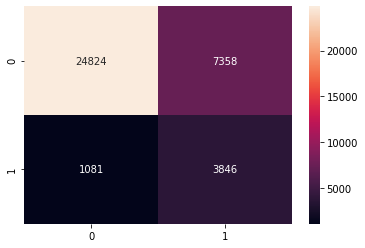

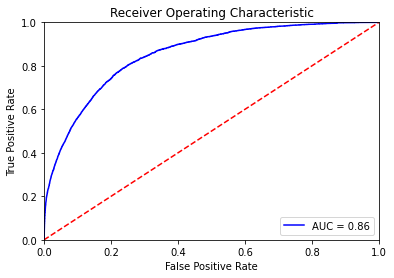


---------------------------------------------------

Training: epoch 2
Avg. Train Loss: 0.59, Step: 0, depleted: 0.0%
Avg. Train Loss: 0.368, Step: 1000, depleted: 9.55%
Avg. Train Loss: 0.374, Step: 2000, depleted: 19.1%
Avg. Train Loss: 0.369, Step: 3000, depleted: 28.64%
Avg. Train Loss: 0.365, Step: 4000, depleted: 38.19%
Avg. Train Loss: 0.37, Step: 5000, depleted: 47.74%
Avg. Train Loss: 0.367, Step: 6000, depleted: 57.29%
Avg. Train Loss: 0.368, Step: 7000, depleted: 66.83%
Avg. Train Loss: 0.363, Step: 8000, depleted: 76.38%
Avg. Train Loss: 0.356, Step: 9000, depleted: 85.93%
Avg. Train Loss: 0.36, Step: 10000, depleted: 95.48%
Model distilbert_under_1_epoch_1 saved!

***************************************************

Evaluation
Batches validated: 0
Batches validated: 1000
Batches validated: 2000
Batches validated: 3000
Batches validated: 4000
Validation done!


AUC: 0.8566
Accuracy: 80.55%
F1 score: 0.49386352479135986
[[26371  5811]
 [ 1406  3521]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


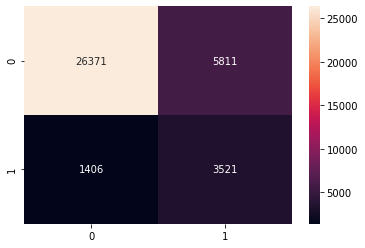

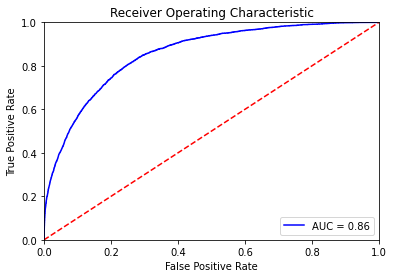


---------------------------------------------------

Training: epoch 3
Avg. Train Loss: 0.102, Step: 0, depleted: 0.0%
Avg. Train Loss: 0.298, Step: 1000, depleted: 9.55%
Avg. Train Loss: 0.304, Step: 2000, depleted: 19.1%
Avg. Train Loss: 0.31, Step: 3000, depleted: 28.64%
Avg. Train Loss: 0.301, Step: 4000, depleted: 38.19%
Avg. Train Loss: 0.321, Step: 5000, depleted: 47.74%
Avg. Train Loss: 0.301, Step: 6000, depleted: 57.29%
Avg. Train Loss: 0.311, Step: 7000, depleted: 66.83%
Avg. Train Loss: 0.319, Step: 8000, depleted: 76.38%
Avg. Train Loss: 0.312, Step: 9000, depleted: 85.93%
Avg. Train Loss: 0.312, Step: 10000, depleted: 95.48%
Model distilbert_under_1_epoch_2 saved!

***************************************************

Evaluation
Batches validated: 0
Batches validated: 1000
Batches validated: 2000
Batches validated: 3000
Batches validated: 4000
Validation done!


AUC: 0.8483
Accuracy: 80.03%
F1 score: 0.4875553097345132
[[26171  6011]
 [ 1401  3526]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


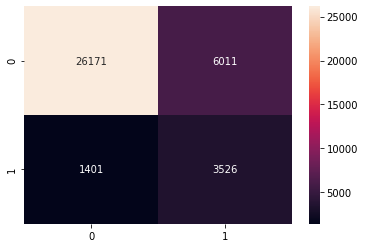

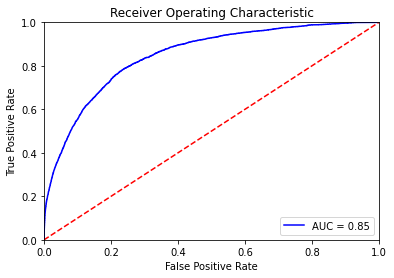


---------------------------------------------------

Training: epoch 4
Avg. Train Loss: 0.121, Step: 0, depleted: 0.0%
Avg. Train Loss: 0.244, Step: 1000, depleted: 9.55%
Avg. Train Loss: 0.26, Step: 2000, depleted: 19.1%
Avg. Train Loss: 0.267, Step: 3000, depleted: 28.64%
Avg. Train Loss: 0.265, Step: 4000, depleted: 38.19%
Avg. Train Loss: 0.267, Step: 5000, depleted: 47.74%
Avg. Train Loss: 0.264, Step: 6000, depleted: 57.29%
Avg. Train Loss: 0.27, Step: 7000, depleted: 66.83%
Avg. Train Loss: 0.273, Step: 8000, depleted: 76.38%
Avg. Train Loss: 0.263, Step: 9000, depleted: 85.93%
Avg. Train Loss: 0.271, Step: 10000, depleted: 95.48%
Model distilbert_under_1_epoch_3 saved!

***************************************************

Evaluation
Batches validated: 0
Batches validated: 1000
Batches validated: 2000
Batches validated: 3000
Batches validated: 4000
Validation done!


AUC: 0.8353
Accuracy: 75.76%
F1 score: 0.45836093213705065
[[24308  7874]
 [ 1121  3806]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


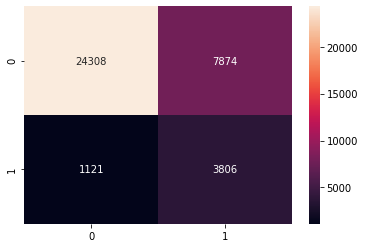

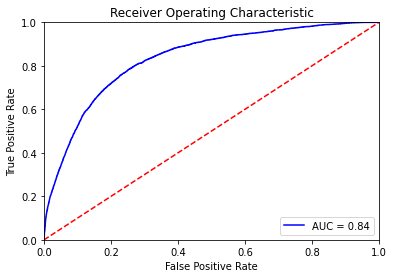


---------------------------------------------------

Training: epoch 5
Avg. Train Loss: 0.007, Step: 0, depleted: 0.0%
Avg. Train Loss: 0.221, Step: 1000, depleted: 9.55%
Avg. Train Loss: 0.229, Step: 2000, depleted: 19.1%
Avg. Train Loss: 0.237, Step: 3000, depleted: 28.64%
Avg. Train Loss: 0.238, Step: 4000, depleted: 38.19%
Avg. Train Loss: 0.226, Step: 5000, depleted: 47.74%
Avg. Train Loss: 0.215, Step: 6000, depleted: 57.29%
Avg. Train Loss: 0.226, Step: 7000, depleted: 66.83%
Avg. Train Loss: 0.221, Step: 8000, depleted: 76.38%
Avg. Train Loss: 0.233, Step: 9000, depleted: 85.93%
Avg. Train Loss: 0.219, Step: 10000, depleted: 95.48%
Model distilbert_under_1_epoch_4 saved!

***************************************************

Evaluation
Batches validated: 0
Batches validated: 1000
Batches validated: 2000
Batches validated: 3000
Batches validated: 4000
Validation done!


AUC: 0.8293
Accuracy: 76.99%
F1 score: 0.4638955167650383
[[24877  7305]
 [ 1233  3694]]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


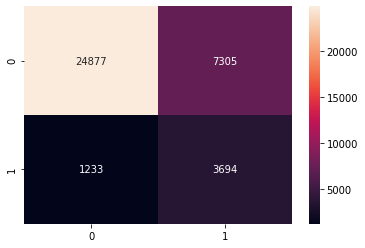

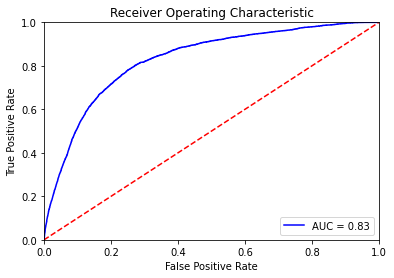


---------------------------------------------------



In [159]:
train_eval(batch_train, model, optimizer, scheduler, epochs, device, batchsize, val_dataloader)

In [ ]:
#In case you want to load the own trained BERT on the dataset:

#model = DistilBertForSequenceClassification.from_pretrained('/content/drive/MyDrive/cheers_challenge/round1/models/distilbert_1')
#model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0): TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
       